# Data processing
### 1. Imports

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

### 2. Recuperation of the data in the csv files 

In [93]:
test_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PreTest-Scores.csv")).set_index('ID')
prof_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PreTest+ParticipantInfo.csv")).set_index('ID')

game_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-Game-ExtractedVariables.csv")).set_index('ID')
game_txt_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-Game-TextCoding.csv")).set_index('ID')

end_answer_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PostTest.csv")).set_index('ID')
end_txt_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PostTest-TextCoding.csv")).set_index('ID')

### 3. Data analysis


#### 3.1. Splitting of the data by theme

In [224]:
# user information + result of the IRI and IPMQ tests
d_profile = pd.DataFrame({'group':prof_data['Group'] , 'gender':prof_data['StrataGender'], 'age':prof_data['pre_Age'], 'uni':prof_data['StrataUniv'], 'level':prof_data['StrataLevel'], 'ml':prof_data['MLScore_weighted'], 'ethics':prof_data['EthicsScore_weighted'], 'IPMQ':test_data['IPMQ-Score-scaled'], 'IRI':test_data['IRI-Score-scaled']})
d_profile = pd.get_dummies(d_profile, prefix=['', '', '', '']) #one hot encoding

# decisions made during the game (no text, no emoji, no control group)
d_decisions = pd.DataFrame({'accept':game_data['menu1_answer'], 'jail_data': game_data['menu2_answer'], 'loop': game_data['looped'], 'translate_data':game_data['menu3_answer']})
d_decisions = d_decisions.replace({'STRAIGHT': 0.0,'0': 0.0,'0$0': 0.0,'0$1': 0.0, '0$1$0': 0.0, 'LOOPED': 1.0, '1': 1.0,'1$0': 1.0, '1$0$1': 1.0})

# themes recognized in the texts by the humans
d_game_text_themes = game_txt_data[game_txt_data['Group']=='ExpReflection'].drop(columns=['Group', 'jail_email', 'jail_reflection', 'Empty']).fillna(0.0)
d_end_text_themes = end_txt_data.drop(columns=['Group', 'post_Learned']).fillna(0.0)

#emoji of the users in one hot encoding
d_emoji = game_data[game_data.columns[game_data.columns.str.startswith('emoji')]].drop(columns=['emoji_answer','emojiJail_answer', 'emojiTranslator_all_answer'])

#all of the info
d_all = pd.concat([d_profile, d_decisions, d_game_text_themes, d_end_text_themes, d_emoji], axis=1)

### 3.2. Missing values

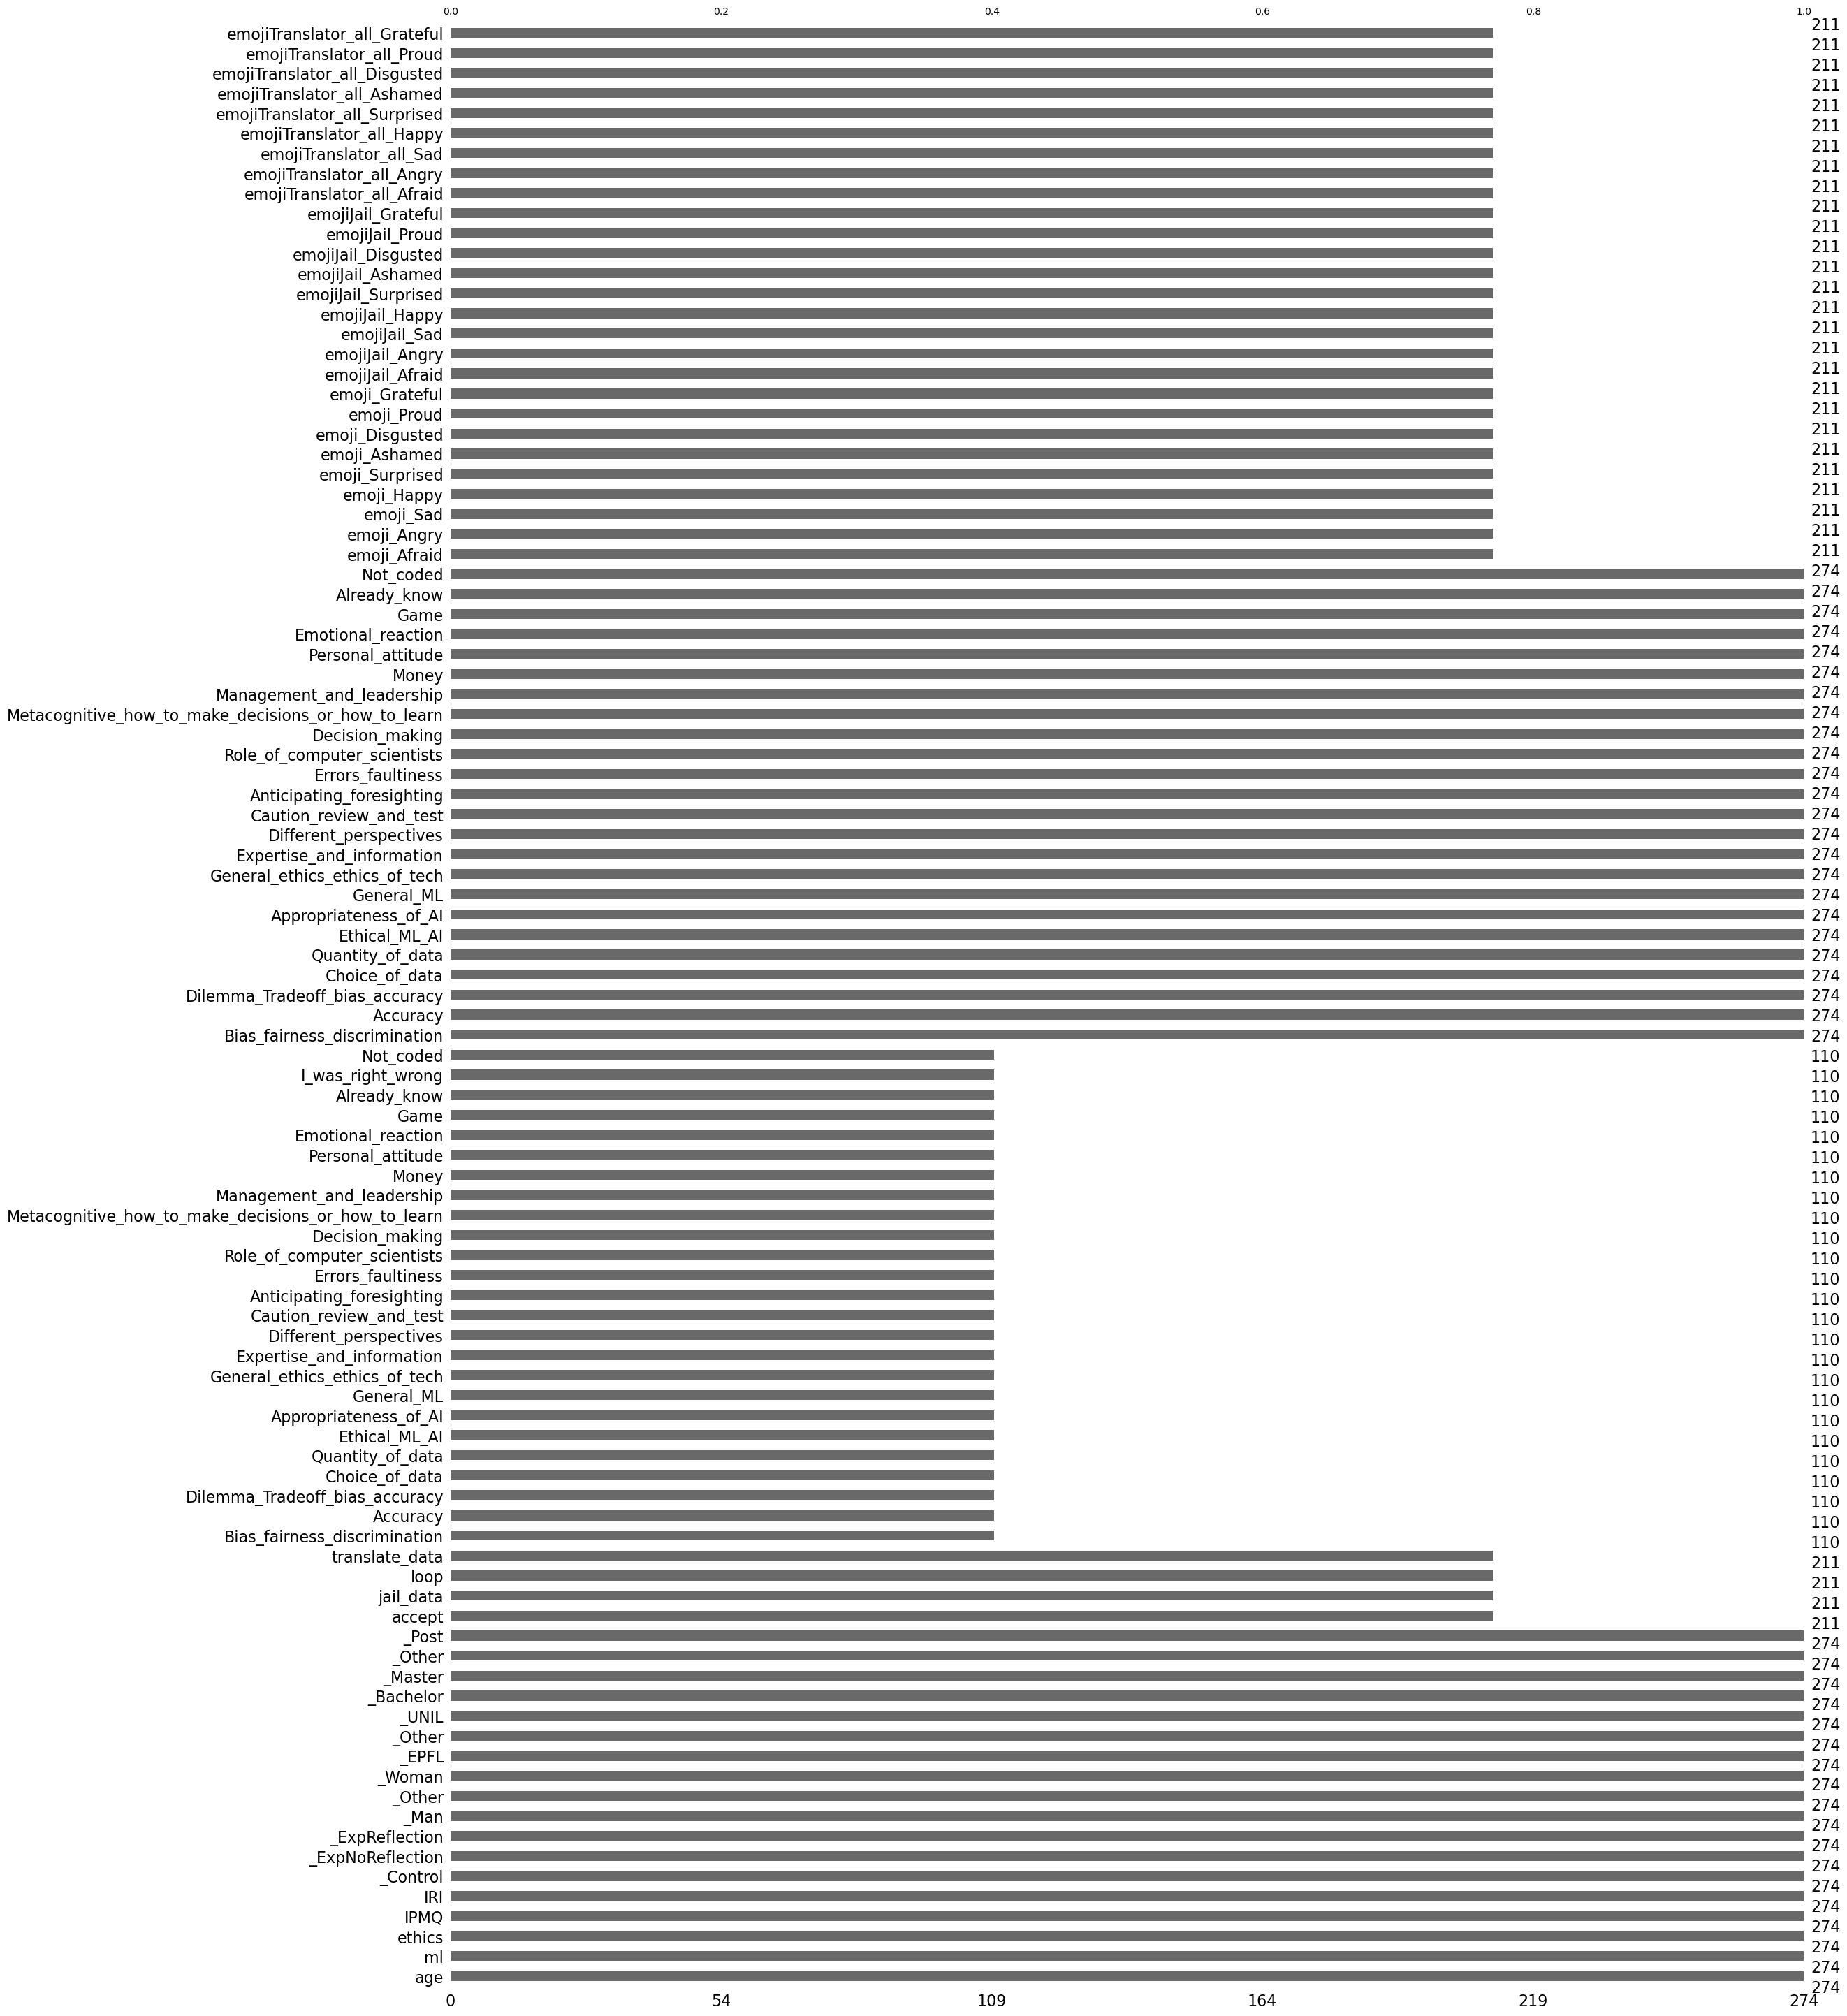

expected size for game_txt: 110
expected size for the decisions, emoji: 211
expected size for the profile, end_txt: 274


In [225]:
msno.bar(d_all)
plt.show()

control = (prof_data['Group'] == 'Control').sum()
reflexion = (prof_data['Group'] == 'ExpReflection').sum()
no_reflexion = (prof_data['Group'] == 'ExpNoReflection').sum()

print('expected size for game_txt:', reflexion)
print('expected size for the decisions, emoji:', reflexion + no_reflexion)
print('expected size for the profile, end_txt:', reflexion + no_reflexion + control)

We can observe that there are no missing values: each group has indeed the correct number of non-NaN entries

#### 3.3. Standardisation

In [226]:
# Only for the continuous values -> the profile
scaler = StandardScaler().fit(d_profile[['age', 'ml', 'ethics', 'IPMQ', 'IRI']])
d_profile[['age', 'ml', 'ethics', 'IPMQ', 'IRI']] = scaler.transform(d_profile[['age', 'ml', 'ethics', 'IPMQ', 'IRI']])

### 4. Can the game be used to develop the ethical sensitivity of students in the domain of Machine Learning?


#### 4.1. Prediction of whether the student has learned about ethic or not

##### 4.1.1. Creation and split of the Dataset
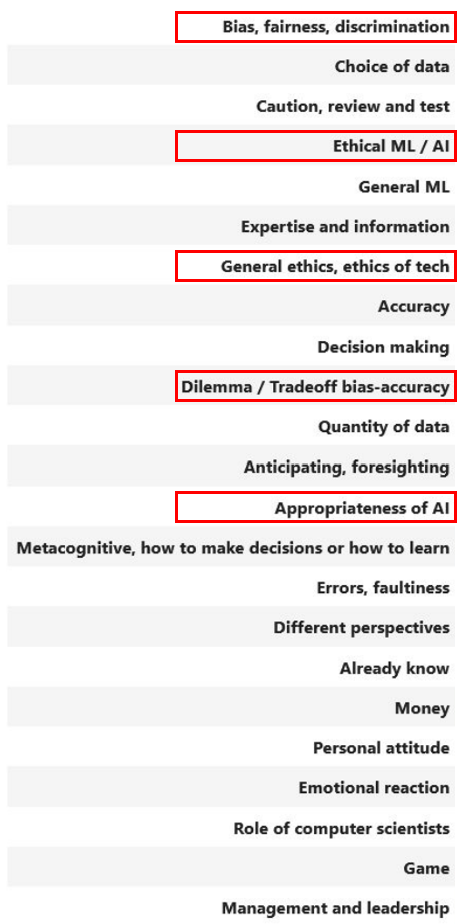

The student has learned about ethic if the end text contains one of the themes in red <br>
<img src="../images/ethic_themes.png" width="30%" height="30%">

In [227]:
# creation of the dataset
themes = d_end_text_themes[['Bias_fairness_discrimination', 'Ethical_ML_AI', 'General_ethics_ethics_of_tech', 'Dilemma_Tradeoff_bias_accuracy', 'Appropriateness_of_AI']].any(axis=1)
data = pd.concat([d_profile, themes], axis=1)

# 60% for train, 20% for validation and test, we don't train with the control group
train, test = np.split(data.sample(frac=1), [int(0.75*len(data))])

##### 4.1.2. Logistic regression for the prediction

accuracy: 0.8840579710144928


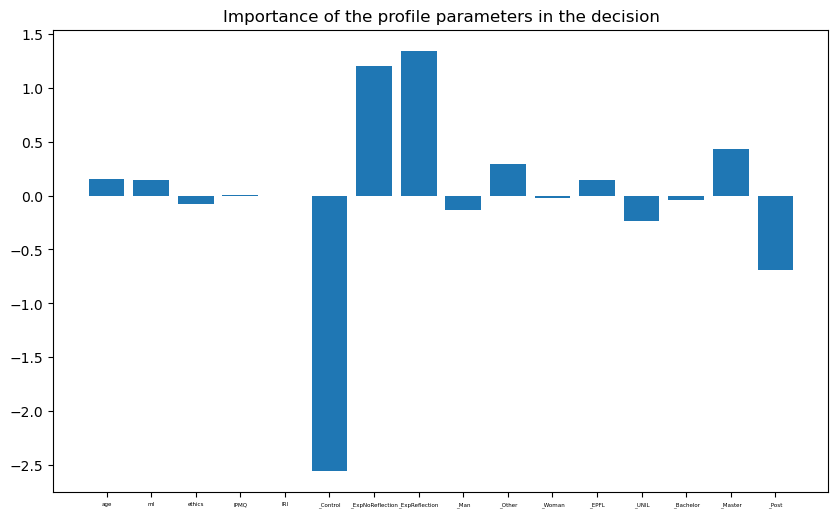

In [237]:
#C is the regularisation, small -> strong regularization
model = LogisticRegression(penalty='l2', C=1.0)

model.fit(train.iloc[:, :-1], train.iloc[:, -1])

print('accuracy:', model.score(test.iloc[:, :-1], test.iloc[:, -1]))

plt.figure(figsize=(10,6))
plt.xticks(fontsize=4)
plt.bar(train.columns[:-1], model.coef_.reshape(-1))
plt.title('Importance of the profile parameters in the decision')
plt.show()

##### 4.1.3. MLP for the prediction

In [119]:
df = pd.DataFrame({'month': [1, 4, 7, 10],

                   'year': [2012, 2014, 2013, 2014],

                   'sale': [55, 40, 84, 31]})

df

,month,year,sale
0,1,2012,55
1,4,2014,40
2,7,2013,84
3,10,2014,31
